# Logistic Regression and Neural Nets
## Foundations of Machine Learning
## `! git clone https://www.github.com/DS3001/aNN_preview`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import seaborn as sns

## Logistic Regression and Neural Networks
- We've covered classical algorithms (kNN, kMC, linear models, decision trees) and more modern tools (ensembles, random forests, LASSO)
- The next big jump is to neural networks
- To prepare for that, we'll look at logistic regression today, and build your first neural net

## Logistic Regression
- One of our complaints about linear models for predicting a binary class or a probability is that it might take values less than zero or greater than 1
- There are a variety of ways to fix this, but the most popular are **probit** and **logit**
- The basic premise of these models is that there is an unobserved linear index or **latent variable**,
$$ L_i = b \cdot x_i + \varepsilon_i,$$
but what is observed is
$$ y_i = \begin{cases} 1, & L_i \ge 0 \\ 0, & L_i < 0 \end{cases} $$
- So if the latent index is large or the shock is particularly large, you'll observe a 1; otherwise you observe a zero
- Classic example: Who buys a new waching machine this year ($y_i =1, 0$), based on socio-economic characteristics $x_i$?

## Logistic (and Probit) Regression
- To fit these models, we first pick a distribution function for $\varepsilon_i$, $F(x) =pr[\varepsilon_i \le x]$:
    - If we pick $F(x) = \dfrac{1}{1+\exp(-x)}$, we get **Logistic Regression**
    - If we pick the normal distribution, the probability of observing a 1 given $x_i$ is $\Phi(\varepsilon_i)$, where $\Phi$ is the standard normal distribution function, $$ \Phi(\varepsilon_i) = \int_{-\infty}^{\varepsilon_i} \dfrac{1}{\sqrt{2 \pi}} e^{-z^2/2} dz$$ and we get **Probit Regression**
- In 2023, there is little reason to pick one or the other, but 30-40 years ago, the logistic distribution had an advantage because it was easier to compute than the standard normal distribution

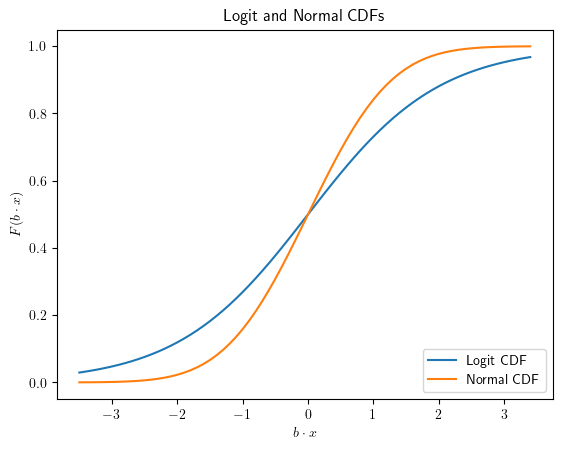

In [2]:
X = np.arange(-3.5,3.5,.1) # Create grid for plot

def F(L): # Logit distribution function
    p = 1/(1+np.exp(-L))
    return p

pr_logit = F(X) # Evaluate logit CDF on grid
pr_normal = norm.cdf(X) # Evaluate normal CDF on grid

# Plot:
plt.rcParams['text.usetex'] = True
plt.plot(X,pr_logit, label ='Logit CDF')
plt.plot(X, pr_normal, label='Normal CDF')
plt.xlabel("$b \cdot x$")
plt.ylabel("$F(b\cdot x)$")
plt.legend(loc='lower right')
plt.title('Logit and Normal CDFs')
plt.show()

## Logistic Regression
- What is the probability of observing a 0, given $x_i$? We want to make the following probability "look like" a distribution function so can swap in $F(x)=pr[\varepsilon_i \le x]$:
$$\begin{eqnarray*}
pr[y=0|x] &=& pr[ b \cdot x_i + \varepsilon_i \le 0 ] \\
&=& pr[  \varepsilon_i \le - b \cdot x_i ] \\
&=& F( - b \cdot x_i) \\
&=& \dfrac{1}{1+\exp(b \cdot x_i)}
\end{eqnarray*}$$
Since $pr[y=0|x] = 1 - pr[y=1|x]$, using our probability rules, that implies that
$$\begin{eqnarray*}
pr[y=1|x] &=& 1 - \dfrac{1}{1+\exp(b \cdot x_i)} \\
&=& \dfrac{\exp(b \cdot x_i)}{1+\exp(b \cdot x_i)}\\
&=& \dfrac{1}{1+\exp(-b \cdot x_i)}
\end{eqnarray*}$$
As you vary $b$, it shapes the probability of observing $y=1$ or $y=0$, 

## Example: Price Discrimination
- The data: You observe data $x_i$ about a consumer and whether they purchased ($y_i=1$) or not ($y_i = 0$) at a price of $p_i$
- You want to build a model that describes how future consumers will respond to different prices.
- The consumer buys if their value, $v_i$, exceeds the price, $p_i$, or $v_i - p_i \ge 0$ 
- Model their net gain as $n_i = b \cdot x_i + \varepsilon_i - p_i$ and substitute into the logit model: $$ \begin{eqnarray} pr[\text{buy}|p_i, x_i] &=& pr[n_i \ge 0 ] \\
&=& pr[\varepsilon_i \ge -(b \cdot x_i - p_i) ] \\
&=& 1 - pr[\varepsilon_i < -(b \cdot x_i - p_i) ] \\
&=& 1 - F(-(b \cdot x_i - p_i)) \\
&=& 1 - \dfrac{1}{1+\exp(b \cdot x_i - p_i)} \\
&=&  \dfrac{1}{1+\exp(b \cdot x_i - p_i)} \end{eqnarray}$$
- So you can map consumer characteristics into a probability of purchase. This is a workhorse model for price-setting.

## How to Fit A Logistic Regression Model
- You could compute the SSE of the predicted probabilities from the observed outcomes: This is called the **Brier Score**
- Typically, we instead pick $b$ to maximize the probability of observing the data
- $1-F(-b \cdot x_i)$ is the probability of observing a 1, so the probability of observing a zero is $F(-b \cdot x_i)$
- Then the probability of observing these data given $b$ is given by the **likelihood function**,
$$ pr[y|x,b] = \prod_{i: y_i =1} \dfrac{1}{1+\exp(-b \cdot x_i)} \times  \prod_{i: y_i = 0}  \dfrac{1}{1+\exp(b \cdot x_i)}=L(b)$$
We pick $b$ to maximize the log of this quantity using calculus (gradient descent, Newton's method), which is not as bad as it might appear.
- This is called **maximum likelihood estimation**, and is an alternative way to approach the problem of picking parameters $b$ to fit a model to data that has excellent statistical properties
- You can Lasso a logit model with `glmnet`

## Logistic regression
- Scikit, of course, has a package for this:
    - `from sklearn.linear_model import LogisticRegression`
- Logistic regression is a regression object, just like `LinearRegression`
- Logistic regression does not, strictly speaking, have an $R^2$ since it is a classification tool

In [3]:
## Example
pd.set_option('display.max_columns', None)
df = pd.read_csv('./data/brazil_default.csv', encoding = 'latin1', low_memory = False)
df.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,STATE_OF_BIRTH,CITY_OF_BIRTH,NACIONALITY,RESIDENCIAL_STATE,RESIDENCIAL_CITY,RESIDENCIAL_BOROUGH,FLAG_RESIDENCIAL_PHONE,RESIDENCIAL_PHONE_AREA_CODE,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_MOBILE_PHONE,FLAG_EMAIL,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OTHER_CARDS,QUANT_BANKING_ACCOUNTS,QUANT_SPECIAL_BANKING_ACCOUNTS,PERSONAL_ASSETS_VALUE,QUANT_CARS,COMPANY,PROFESSIONAL_STATE,PROFESSIONAL_CITY,PROFESSIONAL_BOROUGH,FLAG_PROFESSIONAL_PHONE,PROFESSIONAL_PHONE_AREA_CODE,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,EDUCATION_LEVEL.1,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,RN,Assu,1,RN,Santana do Matos,Centro,Y,105,1.0,15.0,N,1,900.0,0.0,1,1,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,9.0,4.0,NaN,NaN,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,RJ,rio de janeiro,1,RJ,RIO DE JANEIRO,CAMPO GRANDE,Y,20,1.0,1.0,N,1,750.0,0.0,0,0,0,0,0,0,0,0.0,0,Y,,NaN,NaN,N,,0,11.0,4.0,11.0,NaN,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,RN,GARANHUNS,1,RN,Parnamirim,Boa Esperanca,Y,105,1.0,NaN,N,1,500.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,11.0,NaN,NaN,NaN,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,PE,CABO,1,PE,CABO,PONTE DOS CARVALHOS,N,,NaN,NaN,N,1,500.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,NaN,NaN,NaN,NaN,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,RJ,RIO DE JANEIRO,1,RJ,Rio de Janeiro,Santa Cruz,Y,20,1.0,12.0,N,1,1200.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,9.0,5.0,NaN,NaN,0,0,0,0,1,N,48,235,235,1


In [4]:
df.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,NACIONALITY,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_EMAIL,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OTHER_CARDS,QUANT_BANKING_ACCOUNTS,QUANT_SPECIAL_BANKING_ACCOUNTS,PERSONAL_ASSETS_VALUE,QUANT_CARS,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,EDUCATION_LEVEL.1,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,AGE,TARGET_LABEL_BAD=1
count,50000.000000,50000.000000,50000.0,50000.000000,50000.00000,50000.000000,50000.0,50000.000000,48651.000000,46223.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,42244.000000,42687.000000,21116.000000,17662.000000,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.00000,50000.000000
mean,25000.500000,12.869920,0.0,1.006540,2.14840,0.650520,0.0,0.961600,1.252225,9.727149,0.802280,886.678437,35.434760,0.111440,0.097460,0.001320,0.001740,0.002040,0.357840,0.357840,2.322372e+03,0.336140,0.009320,8.061784,2.484316,3.797926,0.296003,0.0,0.0,0.0,0.0,1.275700,43.24852,0.260820
std,14433.901067,6.608385,0.0,0.080606,1.32285,1.193655,0.0,0.202105,0.867833,10.668841,0.398284,7846.959327,891.515142,0.314679,0.296586,0.036308,0.041677,0.045121,0.479953,0.479953,4.235798e+04,0.472392,0.383453,3.220104,1.532261,5.212168,0.955688,0.0,0.0,0.0,0.0,0.988286,14.98905,0.439086
min,1.000000,1.000000,0.0,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,6.00000,0.000000
25%,12500.750000,10.000000,0.0,1.000000,1.00000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,360.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,31.00000,0.000000
50%,25000.500000,10.000000,0.0,1.000000,2.00000,0.000000,0.0,1.000000,1.000000,6.000000,1.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,9.000000,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,41.00000,0.000000
75%,37500.250000,15.000000,0.0,1.000000,2.00000,1.000000,0.0,1.000000,1.000000,15.000000,1.000000,800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,9.000000,4.000000,11.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,53.00000,1.000000
max,50000.000000,25.000000,0.0,2.000000,7.00000,53.000000,0.0,2.000000,5.000000,228.000000,1.000000,959000.000000,194344.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,6.000000e+06,1.000000,35.000000,18.000000,5.000000,17.000000,5.000000,0.0,0.0,0.0,0.0,7.000000,106.00000,1.000000


In [5]:
df = pd.read_csv('./data/brazil_default.csv', encoding = 'latin1', low_memory = False)

# 'AGE', 'SEX'

df['Intercept'] = np.ones(df.shape[0])

num_var = ['Intercept','PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES','FLAG_EMAIL', 
          'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS', 'FLAG_MASTERCARD', 'FLAG_OTHER_CARDS', 
          'PERSONAL_ASSETS_VALUE']
cat_var = ['MARITAL_STATUS', 'QUANT_DEPENDANTS','QUANT_BANKING_ACCOUNTS', 'QUANT_CARS', 
           'EDUCATION_LEVEL.1','PROFESSION_CODE']

df = df.loc[:, ['TARGET_LABEL_BAD=1']+num_var+cat_var ]

In [6]:
df.isnull().describe()

,TARGET_LABEL_BAD=1,Intercept,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,FLAG_EMAIL,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_MASTERCARD,FLAG_OTHER_CARDS,PERSONAL_ASSETS_VALUE,MARITAL_STATUS,QUANT_DEPENDANTS,QUANT_BANKING_ACCOUNTS,QUANT_CARS,EDUCATION_LEVEL.1,PROFESSION_CODE
count,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
freq,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,32338,42244


In [7]:
print(df['PROFESSION_CODE'].value_counts())
df['PROFESSION_CODE'] = df['PROFESSION_CODE'].replace(np.nan,'Missing')
print(df['PROFESSION_CODE'].value_counts())

print(df['EDUCATION_LEVEL.1'].value_counts())
df['EDUCATION_LEVEL.1'] = df['EDUCATION_LEVEL.1'].replace(np.nan,'Missing')
print(df['EDUCATION_LEVEL.1'].value_counts())

PROFESSION_CODE
9.0     30092
11.0     3545
0.0      3540
2.0      2827
12.0      489
10.0      425
16.0      344
13.0      313
7.0       216
8.0       144
6.0       136
15.0       63
17.0       35
4.0        27
3.0        18
5.0        12
14.0        9
1.0         8
18.0        1
Name: count, dtype: int64
PROFESSION_CODE
9.0        30092
Missing     7756
11.0        3545
0.0         3540
2.0         2827
12.0         489
10.0         425
16.0         344
13.0         313
7.0          216
8.0          144
6.0          136
15.0          63
17.0          35
4.0           27
3.0           18
5.0           12
14.0           9
1.0            8
18.0           1
Name: count, dtype: int64
EDUCATION_LEVEL.1
0.0    15995
3.0      621
4.0      615
2.0      342
1.0       56
5.0       33
Name: count, dtype: int64
EDUCATION_LEVEL.1
Missing    32338
0.0        15995
3.0          621
4.0          615
2.0          342
1.0           56
5.0           33
Name: count, dtype: int64


In [8]:
print(np.sum( df.isnull() ))

TARGET_LABEL_BAD=1         0
Intercept                  0
PERSONAL_MONTHLY_INCOME    0
OTHER_INCOMES              0
FLAG_EMAIL                 0
FLAG_DINERS                0
FLAG_AMERICAN_EXPRESS      0
FLAG_MASTERCARD            0
FLAG_OTHER_CARDS           0
PERSONAL_ASSETS_VALUE      0
MARITAL_STATUS             0
QUANT_DEPENDANTS           0
QUANT_BANKING_ACCOUNTS     0
QUANT_CARS                 0
EDUCATION_LEVEL.1          0
PROFESSION_CODE            0
dtype: int64


Accuracy:  0.7392


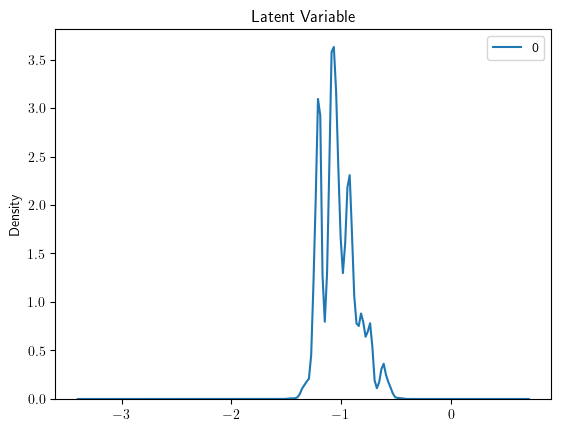

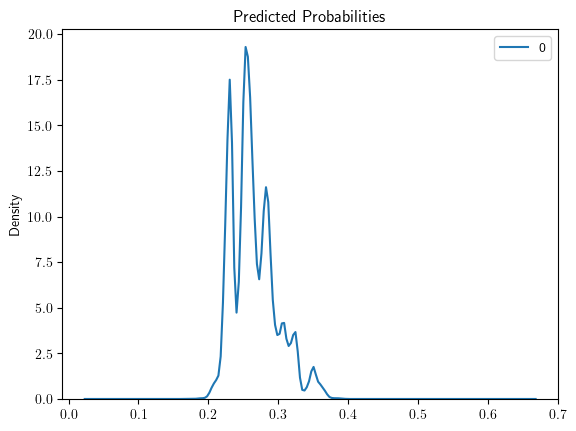

In [9]:
from sklearn.linear_model import LogisticRegression

# Outcome variable:
y = df['TARGET_LABEL_BAD=1']

# Create dummies:
X_n = df.loc[:,num_var]
dummies = pd.DataFrame([]) # In general, use lists and append instead of DataFrame and pd.concat
for var in cat_var: 
    new_dummies = pd.get_dummies( df.loc[:,var], drop_first=True, dtype=int)
    dummies = pd.concat([dummies, new_dummies], axis=1, ignore_index=True) 
    
X = pd.concat([X_n,dummies],axis=1) 
X.columns = X.columns.astype(str)

# Fit logistic regression:
reg = LogisticRegression(fit_intercept=False).fit(X,y)
print('Accuracy: ', reg.score(X,y))

# Latent variable:
latent = np.matmul( X, reg.coef_.T  )
sns.kdeplot(latent).set_title('Latent Variable')
plt.show()

# Probability of default:
pr_hat = 1/(1+np.exp(-latent))
sns.kdeplot(pr_hat).set_title('Predicted Probabilities')
plt.show()


## Multinomial Logit
- If you have more than two discrete outcomes, you can still use the Logit model, unlike the Linear Probability Model
- For each outcome $k=1,...,K$, you have a latent variable $L^k_i = \beta_k \cdot x_i + \varepsilon_{ik}$
- Imagine deciding which make/model of a car to buy, or which ready-to-eat cereal to purchase: $L^k_i$ is how much you like option $k$
- The outcome is the maximum value over all the latent indices $(L^1_i, L^2_i, ..., L^K_i)$: $y_i = \text{argmax}_k L_{ik}$
- Imagine deciding which make/model of a car to buy, or which ready-to-eat cereal to purchase: $y_i$ is the choice you actually make in terms of brand
- You can show that
$$ pr[y_i = k] = \dfrac{e^{\beta_k \cdot x_i}}{\sum_{j=1}^K e^{\beta_j \cdot x_i}}$$
and fit the model using maximum likelihood,
$$L(\beta_1, \beta_2, ..., \beta_K) = \prod_{i: y_i = 1} \dfrac{e^{\beta_1 \cdot x_i}}{\sum_{j=1}^K e^{\beta_j \cdot x_i}} \prod_{i:y_i = 2} \dfrac{e^{\beta_2 \cdot x_i}}{\sum_{j=1}^K e^{\beta_j \cdot x_i}} \cdot \cdot \cdot \prod_{i: y_i = K} \dfrac{e^{\beta_K \cdot x_i}}{\sum_{j=1}^K e^{\beta_j \cdot x_i}}
$$
- Logit and Multinomial Logit are the simplest "upgrades" of a linear model for classification purposes
- This is popular in marketing and the kind of model you should be "afraid" of, in the sense that we can use information about people $x_i$ to pick parameters $b$ and pick profit-maximizing prices

## How are Logistic Regression and Neural Nets related?
- What is a brain?
- Stimulus occurs: You experience a sight/sound/smell/taste/touch
- The stimulus causes a signal that reaches your brain
- Neurons fire in response and you experience memories/thoughts/etc., or you don't even notice the signal was received
- This process is noisy: Sometimes a smell catchs your attention, sometimes it doesn't
- The premise of an **artificial neural network** is to use this architecture of signal/response to build a machine intelligence
- Artificial neural networks mimic the structure of the brain to mimic the function of human intelligence
- The entry-level model of a neuron is the Logistic Regression model

## The Simplest Neural Network
- In the logistic regression, call $x$ the **input layer** and $y$ the **output**
- All aNN's have input layers and output: the data $x$ and the firing of the neuron $y$
- This is a **single layer** neural network; additional **hidden layers** are added between input and output to model the **architecture** of the network --- the shocks in early/low levels of the network are fed forward to influence whether neurons fire in later/higher levels of the network

![](singleLayer.png)

## Logistic Regression as Neural Net
- Imagine you have one neuron.
- You can... notice? Become aware?
- But allegedly your brain is just a bunch of neurons wired together to produce consciousness
- How do we build up your brain from logit regressions?
- We wire logits together in layers

![](multipleLayer.png)

## Adding Hidden Layers
- To make a network with a hidden layer, we have
    - The input layer, $x$
    - A single hidden layer, $z_k = F(b_k^1 x)$ for $k = 1, ..., K$, which is just $K$ logistic regressions
    - A single output layer, $y = b^o \cdot z = \sum_{k=1}^K b^0_k z_k$, which is just a linear model
- So there's (1) a stimulus $x$, (2) $K$ neurons fire or don't depending on the stimulus, and then (3) the output evaluates as a weighted sum of the neurons that did fire
- You can see, you're going to start accumulating a lot of coefficients to fit (the $K$ vectors of $b^1_k$ coefficients of length $N$, the $b^o$ coefficients) --- regularization is a useful tool here

## How Many Layers?
- How many hidden layers? It depends
- For the kinds of straightforward prediction problems we've looked at in class, probably not more than two; there are analyses and rules-of-thumb that people have developed that suggest two is fine for prediction-type tasks 
- A popular aNN in computer vision (convolutional neural networks) has three layers, as a matter of mathematical necessity (a CNN must have 3 layers to work)
- More than three layers qualifies as "deep learning," which might surprise you
- The power of generative artificial intelligence and large language models comes from having a very deep neural network: ChatGPT has 96 hidden layers and 1.75 billion parameters, which cost about 100k to fit (and about 700k per day to run)

## Other Architecture Questions
- For prediction, aNN are typically **densely connected**: Every node in every layer is connected to every node in the next later
- In general similar to the number of layers, it depends
- These questions increasingly become ones of engineering and experience, but there is a useful result to know, called the Kolmogorov-Arnold Representation Theorem:
    - If $f$ is a continuous function taking a variable $x = (x_1, x_2, ..., x_K)$ into a real number $y$, then $f$ can be written in the form
$
f(x) = \sum_{i=0}^{2K} g \left( \sum_{j=1}^{K} h_{ij}(x_j) \right).
$
- So multi-valued, continuous, real functions naturally have a "layered" representation that looks like an aNN; this is another way to motivate studying them

## Packages for aNN Analysis
- There are a variety of packages for neural network analysis:
    - PyTorch
    - Keras/TensorFlow
    - SciKit
- The aNN support is probably the main reason to use Python, not scikit

## Keras
- Keras is a high-level API for TensorFlow
- 

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

labels = np.ravel(y) # Convert y from a Pandas series to Numpy array

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=100)


net = Sequential() # Initialize network

net.add(Dense(units=5,activation='sigmoid')) # Hidden layer 1
net.add(Dense(units=5,activation='sigmoid')) # Hidden layer 2
net.add(Dense(units=1,activation='sigmoid')) # Output layer

net.compile( loss = 'binary_crossentropy', # 
                optimizer = 'sgd', # Stochastic Gradient Descent
                metrics = ['accuracy'] # Su
               )

net.fit(X_train, y_train, 
        epochs=2,
        verbose=1,
        batch_size=1)


Epoch 1/4
40000/40000 [==============================] - 60s 1ms/step - loss: 0.5756 - accuracy: 0.7386
Epoch 2/4
40000/40000 [==============================] - 53s 1ms/step - loss: 0.5751 - accuracy: 0.7393
Epoch 3/4
40000/40000 [==============================] - 47s 1ms/step - loss: 0.5747 - accuracy: 0.7393
Epoch 4/4
40000/40000 [==============================] - 47s 1ms/step - loss: 0.5747 - accuracy: 0.7393


In [12]:
net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 5)                    305       
                                                                 
 dense_1 (Dense)             (1, 5)                    30        
                                                                 
 dense_2 (Dense)             (1, 1)                    6         
                                                                 
Total params: 341 (1.33 KB)
Trainable params: 341 (1.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
score = net.evaluate(X_test, y_test,verbose=1)
print(score)

313/313 [==============================] - 0s 904us/step - loss: 0.5765 - accuracy: 0.7389
[0.5765348076820374, 0.7389000058174133]


## Beyond the Logistic Function
- The logistic function is a nice place to start because it ties together our linear models discussions with the story about neural networks mimicing human brains, but people often use other models of neurons
- Just to show you what they look like, some options besides $1/(1+\exp(-z))$ include:
    - **Tanh**: $f(x) = \dfrac{e^x-e^{-x}}{e^x+e^{-x}}$
    - **rectified linear unit** or ReLU: $f(x) = \max \{ x, 0 \} $
    - **Leaky ReLU**: $f(x) = \max\{.9x, x\}$
    - **Exponential Linear Unit**: $f(x) = \begin{cases} x, & x>0\\ e^x-1, & x < 0 \end{cases}$
- Ultimately, this is all similar to a linear model: We have to pick all these weights, so we'll be using the derivative/gradient to search for weights that provide the best fit

## Artificial Neural Networks
- There is nothing magical about aNN: They're just a powerful and flexible structure to use to build models out of weighted compositions of linear models, and ultimately very similar to other tools presented in class (in the words of a lot of stats people, "They're just nested nonlinear regressions!@!!!")
- But aNN have accomplished a lot, and continue to be a source of innovation in ML
- At this point, you're ready to embark on a lot of modern work related to machine learning, statistics, neural networks, and beyond

## Conclusion
- Whenever I wrap up this class, I find myself thinking about these quotes:
    - "We must build a new world--a far better world--one in which the eternal dignity of each person is respected." - Truman
    - "The best minds of my generation are thinking about how to make people click ads. That sucks." - Jeff Hammerbacher
 
- Increasingly, I think about these quotes from Robert Oppenheimer:
    - "When you see something that is technically sweet, you go ahead and do it and you argue about what to do about it only after you have had your technical success. That is the way it was with the atomic bomb."
    - "I remembered the line from the Hindu scripture, the Bhagavad Gita…‘I am become death, the destroyer of worlds.’"
 
- So, like, what are you going to do with the rest of your life?